## Import modules

In [1]:
from darkflow.net.build import TFNet
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from keras.models import load_model
import pafy
import datetime as dt
import time

Using TensorFlow backend.


## Config custom darkflow

In [2]:
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth=True
with tf.Session(config=config) as sess:
    options = {
        'model':os.path.join('custom_darkflow','cfg','yolov2.cfg'),
        'load':os.path.join('custom_darkflow','bin','yolov2.weights'),
        'threshold':0.3,
        'gpu':1.0
    }
    tfnet = TFNet(options)

C:\Users\sungsooc\AppData\Local\Continuum\anaconda3\envs\cv-gpu\lib\site-packages\darkflow\dark\darknet.py:54: UserWarning: ./cfg/yolov2.cfg not found, use custom_darkflow\cfg\yolov2.cfg instead
  cfg_path, FLAGS.model))


Parsing custom_darkflow\cfg\yolov2.cfg
Loading custom_darkflow\bin\yolov2.weights ...
Successfully identified 203934260 bytes
Finished in 0.014960289001464844s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky     

## Import hdc_v2 and co-register

In [3]:
model_file_name = 'best-wiehgts-Model_2_2-057-0.314-0.870.hdf5'
chosen_model = load_model(os.path.join('best_models_hdc_v2',model_file_name))

In [4]:
def HappyPrediction(img):
    crop_img = img[result[0]['topleft']['y']:result[0]['bottomright']['y'],result[0]['topleft']['x']:result[0]['bottomright']['x']]
    img_rows = 224
    img_cols = 224
    crop_img = cv2.resize(crop_img,(img_rows,img_cols)).astype('float32')
    crop_img /= 255
    crop_img = np.expand_dims(crop_img,axis=0)
    predict_rate = chosen_model.predict(crop_img)[0][0]
    if predict_rate >= 0.5:
        predict_class = 'happy'
    else: predict_class = 'sad'
    return predict_class,predict_rate


In [5]:
happy_box_color = (255,0,0)
sad_box_color = (0,0,255)
txt_color = (255,255,255)

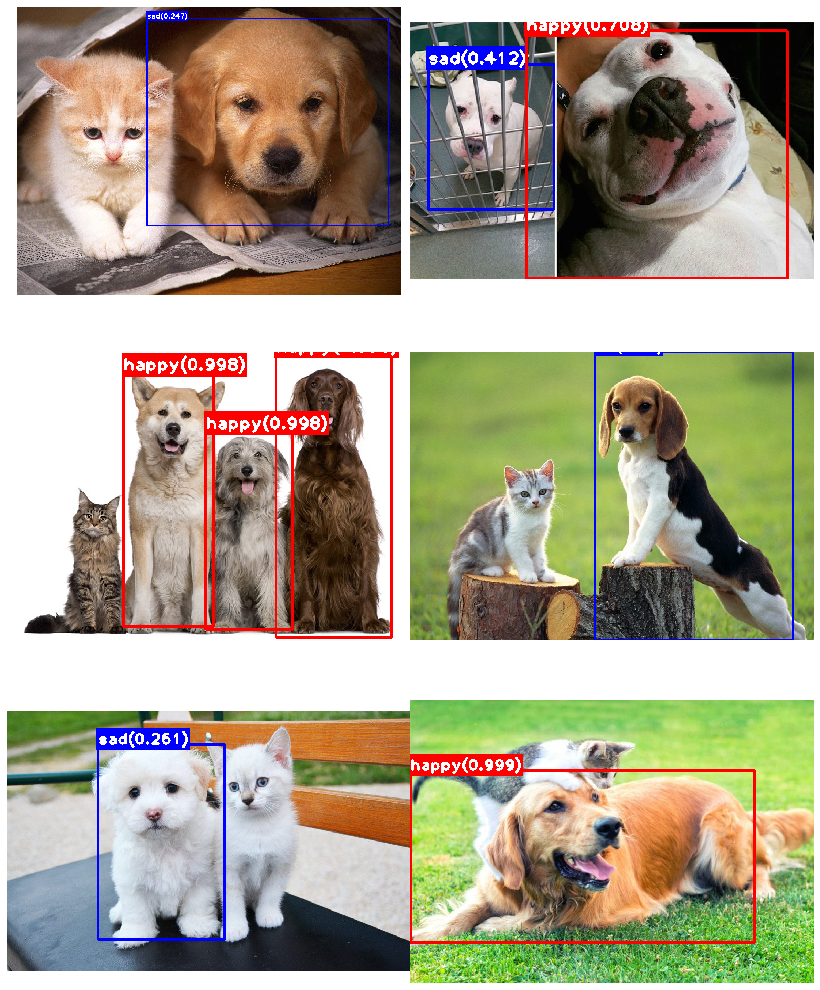

In [6]:
fig, axes = plt.subplots(3, 2,figsize=(8*2, 6*3))
for ax,img_num in zip(axes.flatten(),range(1,7)):
    img = cv2.imread(os.path.join('custom_darkflow','test_images',str(img_num)+'.jpg'))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    result = tfnet.return_predict(img)
    for r in result:
        tl = (r['topleft']['x'], r['topleft']['y'])
        br = (r['bottomright']['x'], r['bottomright']['y'])
        label = r['label']
        if label == 'dog':     
#             conf = r['confidence'] # confidence of general dog detector
#             text = '{}({:.2f})'.format(label,conf)
            predict_class,predict_rate = HappyPrediction(img) # confidence of happy dog classifier
            text = '{}({:.3f})'.format(predict_class,predict_rate)
            (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN,2,5)[0]
            text_offset_x = tl[0]-3
            text_offset_y = tl[1]
            box_coords = ((text_offset_x, text_offset_y+10), (text_offset_x+text_width,text_offset_y-text_height-10))
            if predict_class == 'happy':
                box_color = happy_box_color
            else:
                box_color = sad_box_color
            img = cv2.rectangle(img, box_coords[0], box_coords[1], box_color, cv2.FILLED)
            img = cv2.rectangle(img,tl,br,box_color,thickness=4)
            img = cv2.putText(img,text,tl,cv2.FONT_HERSHEY_PLAIN,2,txt_color,3)
    ax.imshow(img)
    ax.axis('off')
plt.subplots_adjust(left=0.2, wspace=0)

## single example excution time

67.7 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


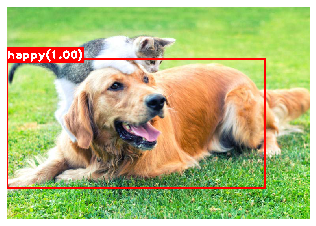

In [7]:
%%timeit
img = cv2.imread(os.path.join('custom_darkflow','test_images','6.jpg'))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
result = tfnet.return_predict(img)
for r in result:
    tl = (r['topleft']['x'], r['topleft']['y'])
    br = (r['bottomright']['x'], r['bottomright']['y'])
    label = r['label']
    if label == 'dog':     
#             conf = r['confidence'] # confidence of general dog detector
#             text = '{}({:.2f})'.format(label,conf)
        predict_class,predict_rate = HappyPrediction(img) # confidence of happy dog classifier
        text = '{}({:.2f})'.format(predict_class,predict_rate)
        (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN,2,5)[0]
        text_offset_x = tl[0]-3
        text_offset_y = tl[1]
        box_coords = ((text_offset_x, text_offset_y+10), (text_offset_x+text_width,text_offset_y-text_height-10))
        if predict_class == 'happy':
            box_color = happy_box_color
        else:
            box_color = sad_box_color
        img = cv2.rectangle(img, box_coords[0], box_coords[1], box_color, cv2.FILLED)
        img = cv2.rectangle(img,tl,br,box_color,thickness=4)
        img = cv2.putText(img,text,tl,cv2.FONT_HERSHEY_PLAIN,2,txt_color,3)
plt.imshow(img)
plt.axis('off')
plt.subplots_adjust(left=0.2, wspace=0)

# for video input

In [8]:
## only showing happy dogs ##
url = 'https://www.youtube.com/watch?v=0lEUiQEDUHM'
pa = pafy.new(url)
play = pa.getbest(preftype='webm')
cap = cv2.VideoCapture(play.url)

if (cap.isOpened() == False):
    print('cannot read a video')
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('HDD_testing.avi',fourcc,20.0,(640,360))

while cap.isOpened():
    stime = time.time()
    ret,frame = cap.read()
    
    if ret == True:
        frame = np.asarray(frame)
        result = tfnet.return_predict(frame)
        new_frame = np.copy(frame)
        for r in result:
            tl = (r['topleft']['x'], r['topleft']['y'])
            br = (r['bottomright']['x'], r['bottomright']['y'])
            label = r['label']
            if label == 'dog':
                predict_class,predict_rate = HappyPrediction(new_frame) # confidence of happy dog classifier
                if predict_class == 'happy':       
                    text = '{}({:.2f})'.format(predict_class,predict_rate)
                    box_color = happy_box_color
                    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN,2,5)[0]
                    text_offset_x = tl[0]-3
                    text_offset_y = tl[1]
                    box_coords = ((text_offset_x, text_offset_y+10), (text_offset_x+text_width,text_offset_y-text_height-10))
                    new_frame = cv2.rectangle(new_frame, box_coords[0], box_coords[1], box_color, cv2.FILLED)
                    new_frame = cv2.rectangle(new_frame,tl,br,box_color,thickness=4)
                    new_frame = cv2.putText(new_frame,text,tl,cv2.FONT_HERSHEY_PLAIN,2,txt_color,3)
        fps = 1/(time.time()-stime)
        new_frame = cv2.putText(new_frame,'fps: '+format(fps, '.2f'),(0,15),cv2.FONT_HERSHEY_PLAIN,1,(0,0,0),2)
        out.write(new_frame)
        cv2.imshow('frame',new_frame)
        if cv2.waitKey(1) & 0xff == ord('q'):
            break
    else:
        break
cv2.destroyAllWindows()
cap.release()
out.release()


In [9]:
url = 'https://www.youtube.com/watch?v=0lEUiQEDUHM'
pa = pafy.new(url)
play = pa.getbest(preftype='webm')
cap = cv2.VideoCapture(play.url)

if (cap.isOpened() == False):
    print('cannot read a video')
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('HDD_testing.avi',fourcc,20.0,(640,360))

while cap.isOpened():
    stime = time.time()
    ret,frame = cap.read()
    
    if ret == True:
        frame = np.asarray(frame)
        result = tfnet.return_predict(frame)
        new_frame = np.copy(frame)
        for r in result:
            tl = (r['topleft']['x'], r['topleft']['y'])
            br = (r['bottomright']['x'], r['bottomright']['y'])
            label = r['label']
            if label == 'dog':
                predict_class,predict_rate = HappyPrediction(new_frame) # confidence of happy dog classifier
                if predict_class == 'happy':       
                    text = '{}({:.2f})'.format(predict_class,predict_rate)
                    box_color = happy_box_color
                else:
                    text = '{}'.format(predict_class)
                    box_color = sad_box_color
                (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN,2,5)[0]
                text_offset_x = tl[0]-3
                text_offset_y = tl[1]
                box_coords = ((text_offset_x, text_offset_y+10), (text_offset_x+text_width,text_offset_y-text_height-10))
#                 if predict_class == 'happy':
#                     box_color = happy_box_color
#                 else:
#                     box_color = sad_box_color
                new_frame = cv2.rectangle(new_frame, box_coords[0], box_coords[1], box_color, cv2.FILLED)
                new_frame = cv2.rectangle(new_frame,tl,br,box_color,thickness=4)
                new_frame = cv2.putText(new_frame,text,tl,cv2.FONT_HERSHEY_PLAIN,2,txt_color,3)
        fps = 1/(time.time()-stime)
        new_frame = cv2.putText(new_frame,'fps: '+format(fps, '.2f'),(0,15),cv2.FONT_HERSHEY_PLAIN,1,(0,0,0),2)
        out.write(new_frame)
        cv2.imshow('frame',new_frame)
        if cv2.waitKey(1) & 0xff == ord('q'):
            break
    else:
        break
cv2.destroyAllWindows()
cap.release()
out.release()


## for webcam input

In [10]:
# colors = (tuple(255*np.random.rand(3) for _ in range(10)))

In [11]:
# capture = cv2.VideoCapture(0)
# capture.set(cv2.CAP_PROP_FRAME_WIDTH,1920)
# capture.set(cv2.CAP_PROP_FRAME_HEIGHT,1080)

In [12]:
# while True:
#     stime = time.time()
#     ret,frame = capture.read()
    
#     if ret:
#         results = tfnet.return_predict(frame)
#         for color,r in zip(colors,results):
#             tl = (r['topleft']['x'], r['topleft']['y'])
#             br = (r['bottomright']['x'], r['bottomright']['y'])
#             label = r['label']
#             frame = cv2.rectangle(frame,tl,br,color,5)
#             frame = cv2.putText(frame,label,tl,cv2.FONT_HERSHEY_PLAIN,2,color,3)
#         cv2.imshow('frame',frame)
#         print('FPS {:.1f}'.format(1/(time.time()-stime)))
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# capture.release()
# cv2.destroyAllWindows()